In [1]:
import os
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.optimize import curve_fit, minimize
from matplotlib import pyplot as plt

/tmp/ipykernel_826543/375655688.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Auxiliary functions
def power_fit(x, m, a, b):
    return m + a*(x**b)

def logistic_fit(alpha, Q, b, v, alpha_N):
    # Implements a more general logistic function (solution of Richards's DE with K=1)
    return 1 / ((1 + Q * np.exp(-b*v*(alpha - alpha_N))) ** (1/v))

def plot_model_curve(results_df, curve_type='probability'):
    assert curve_type in ['probability', 'ext_energy', 'int_energy'], 'Invalid curve type'

    grouped_df = results_df.groupby('N')
    for N, group in grouped_df:
        alphas, means, sems = [], [], []
        alpha_group = group.groupby('alpha')
        for a, g in alpha_group:
            if curve_type == 'probability':
                mean, sem = g["Solved"].mean(), g["Solved"].std()/np.sqrt(g["Solved"].shape[0])
            elif curve_type == 'ext_energy':
                mean, sem = g["Efinale"].mean(), (g["Efinale"].std()/np.sqrt(g["Efinale"].shape[0]))       
            elif curve_type == 'int_energy':
                m = round(a * N)
                mean, sem = g["Efinale"].mean()/m, (g["Efinale"].std()/np.sqrt(g["Efinale"].shape[0]))/m            
            alphas.append(a)
            means.append(mean)
            sems.append(sem)
        plt.errorbar(alphas, means, yerr=sems, fmt='-o', label=f'N={N}')

    plt.xlabel('ɑ', fontsize=18)
    plt.xticks(fontsize=14)
    if curve_type == 'probability':
        plt.ylabel('P(SAT)', fontsize=18)
    elif curve_type == 'ext_energy' or curve_type == 'int_energy':
        plt.ylabel('E', fontsize=18)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

# 3SAT

In [5]:
fixed_result_files = [
    'results_csv/3SAT_results_3SAT_assignment_QuerySAT_unsupervised_2_seed=0_trainS=None_validS=None_perN=True_trainNs=all_01-07-2025-11-07_epoch=127.ckpt_niters128_Nscale2.0.csv'
]

results_csv/3SAT_results_3SAT_assignment_QuerySAT_unsupervised_2_seed=0_trainS=None_validS=None_perN=True_trainNs=all_01-07-2025-11-07_epoch=127.ckpt_niters128_Nscale2.0.csv


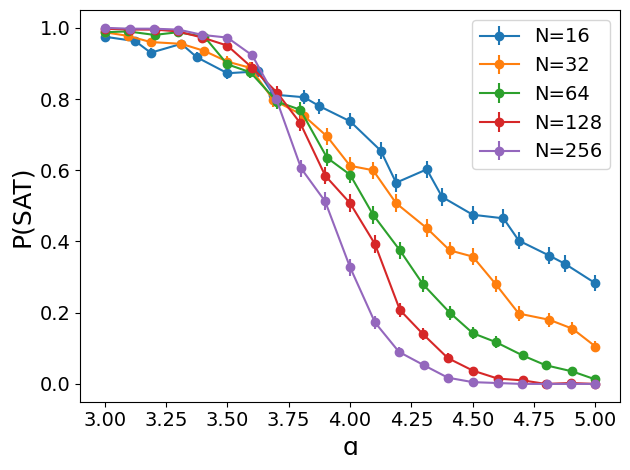

In [6]:
for filepath in fixed_result_files: 
    print(filepath)
    df = pd.read_csv(os.path.normpath(filepath))
    plot_model_curve(df, curve_type='probability')

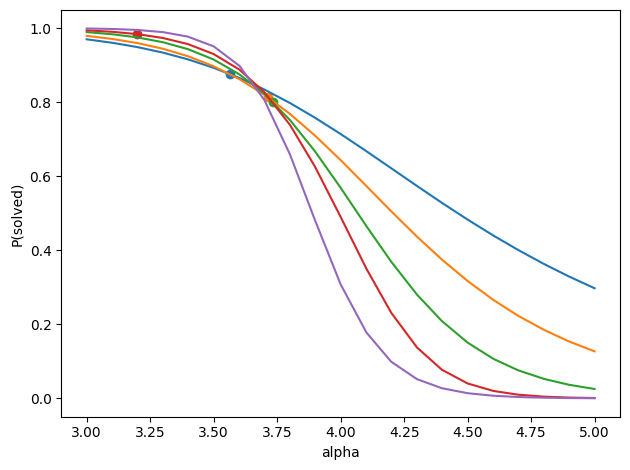

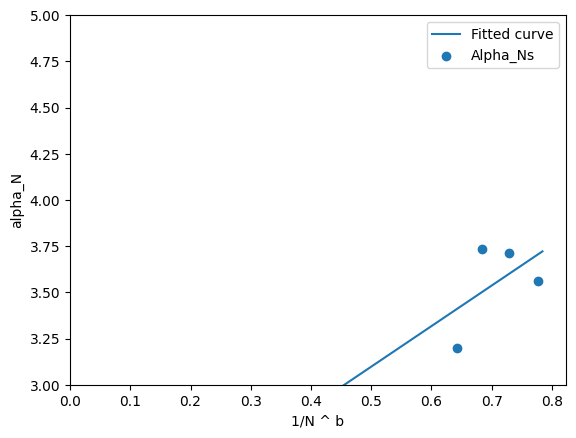

Extrapolated alpha at N ~ infinity: 2.267489162560763
Extrapolated alpha at N -> infinity: 2.0000000000071476



In [7]:
df = pd.read_csv(fixed_result_files[-1])
grouped_df = df.groupby('N')

p_curves, alphas, Ns = [], [], []
for N, group in grouped_df:
    alphas, means, sems = [], [], []
    alpha_group = group.groupby('alpha')
    for a, g in alpha_group:
        p_mean, p_sem = g["Solved"].mean(), g["Solved"].std()/np.sqrt(g["Solved"].shape[0])
        alphas.append(a)
        means.append(p_mean)
        sems.append(p_sem)

    p_curves.append(means)
    Ns.append(N)

x = np.array(alphas)
y1, y2, y3, y4, y5 = p_curves[0], p_curves[1], p_curves[2], p_curves[3], p_curves[4]

# Fit logistic curves to the solving probabilities
popt1, _ = curve_fit(logistic_fit, x, y1, bounds=([0., -np.inf, 0., 3.], [np.inf, np.inf, np.inf, 6.]), maxfev=5000)
popt2, _ = curve_fit(logistic_fit, x, y2, bounds=([0., -np.inf, 0., 3.], [np.inf, np.inf, np.inf, 6.]), maxfev=5000)
popt3, _ = curve_fit(logistic_fit, x, y3, bounds=([0., -np.inf, 0., 3.], [np.inf, np.inf, np.inf, 6.]), maxfev=5000)
popt4, _ = curve_fit(logistic_fit, x, y4, bounds=([0., -np.inf, 0., 3.], [np.inf, np.inf, np.inf, 6.]), maxfev=5000)
popt5, _ = curve_fit(logistic_fit, x, y5, bounds=([0., -np.inf, 0., 3.], [np.inf, np.inf, np.inf, 6.]), maxfev=5000)
f1 = lambda x: logistic_fit(x, *popt1)
f2 = lambda x: logistic_fit(x, *popt2)
f3 = lambda x: logistic_fit(x, *popt3)
f4 = lambda x: logistic_fit(x, *popt4)
f5 = lambda x: logistic_fit(x, *popt5)

# Find the x where the curves intersect (closest to intersecting) via least squares
def intersection_objective_n1(x):
    return (f1(x) -f2(x))**2
result = minimize(intersection_objective_n1, x0=[4.], bounds=[(3.2, 4.8)])
p1_x_intersection = result.x[0]
p1_y_intersection = f1(p1_x_intersection)

def intersection_objective_n2(x):
    return (f2(x)-f3(x))**2
result = minimize(intersection_objective_n2, x0=[4.], bounds=[(3.2, 4.8)])
p2_x_intersection = result.x[0]
p2_y_intersection = f2(p2_x_intersection)

def intersection_objective_n3(x):
    return (f3(x)-f4(x))**2
result = minimize(intersection_objective_n3, x0=[4.], bounds=[(3.2, 4.8)])
p3_x_intersection = result.x[0]
p3_y_intersection = f3(p3_x_intersection)

def intersection_objective_n4(x):
    return (f4(x)-f5(x))**2
result = minimize(intersection_objective_n4, x0=[4.], bounds=[(3.2, 4.8)])
p4_x_intersection = result.x[0] 
p4_y_intersection = f4(p4_x_intersection)

alpha_N_values = [p1_x_intersection, p2_x_intersection, p3_x_intersection, p4_x_intersection]
intersection_y_values = [p1_y_intersection, p2_y_intersection, p3_y_intersection, p4_y_intersection]

f = [f1, f2, f3, f4, f5]
for i in range(len(p_curves)):
    plt.plot(x, f[i](x))
    if i < len(alpha_N_values):
        plt.scatter(alpha_N_values[i], intersection_y_values[i], marker='o')
plt.xlabel('alpha')
plt.ylabel('P(solved)')
plt.tight_layout()
plt.show()

inverse_N = 1 / np.array(Ns)
inverse_N = inverse_N[:-1]
popt, _ = curve_fit(power_fit, inverse_N, alpha_N_values, bounds=[[2., -np.inf, -np.inf], [6., np.inf,  np.inf]],  maxfev=5000)
(m, a, b) = popt
x_range = np.linspace(0, 0.07, 100)
new_x = x_range ** b
new_y = m + a * new_x

plt.plot(new_x, new_y, label='Fitted curve')
plt.scatter(inverse_N ** b, alpha_N_values, label='Alpha_Ns')
plt.xlabel('1/N ^ b')
plt.ylabel('alpha_N')
plt.xlim(left=0)
plt.ylim((3,5))
plt.legend()
plt.show()

print("Extrapolated alpha at N ~ infinity:", power_fit(1e-10, *popt))
print("Extrapolated alpha at N -> infinity:", popt[0])
print()

In [8]:
#  calculate percentange of solvable (as per their label) instances that were actually solved
labels = pd.read_csv(os.path.normpath('../../datasets/3SAT/sc/test_labels-final.csv'))
print(df.shape, labels.shape)
sat_idx = np.where(labels.sat == 1)[0]
pred, gt = df.Solved[sat_idx], labels.sat[sat_idx]
print(pred.shape, gt.shape)
print('Solving accuracy:', (pred == gt).sum() / len(gt))

(42000, 6) (42000, 3)
(28656,) (28656,)
Solving accuracy: 0.8090452261306532


In [9]:
df[df['E'] == 0].shape, df.shape

((23184, 6), (42000, 6))

# 4SAT

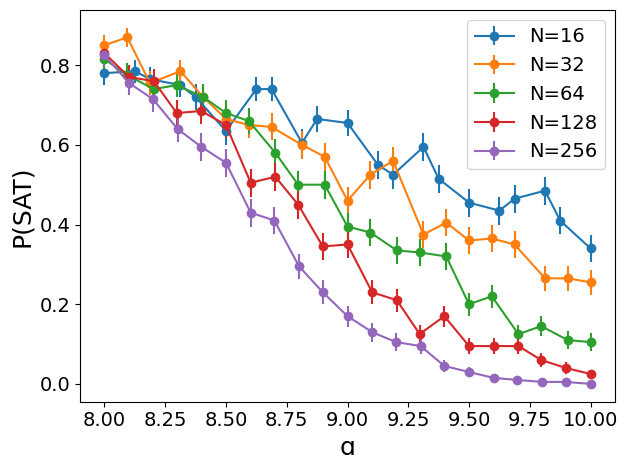

In [10]:
filepath = 'results_csv/4SAT_results_4SAT_assignment_QuerySAT_unsupervised_2_seed=0_trainS=None_validS=None_perN=True_trainNs=all_01-07-2025-11-35_epoch=272.ckpt_niters128_Nscale2.0.csv'
df = pd.read_csv(os.path.normpath(filepath))
plot_model_curve(df, curve_type='probability')

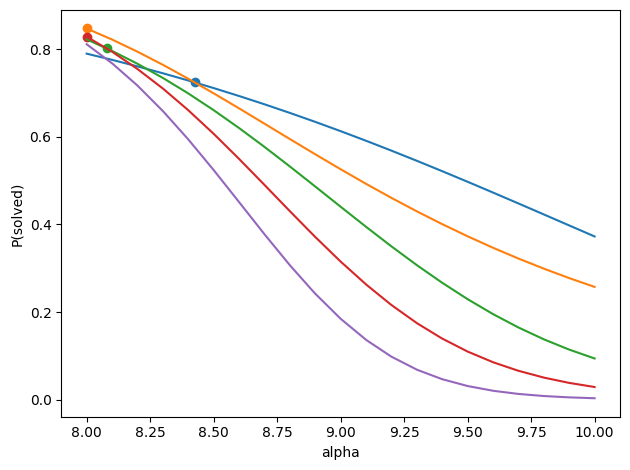

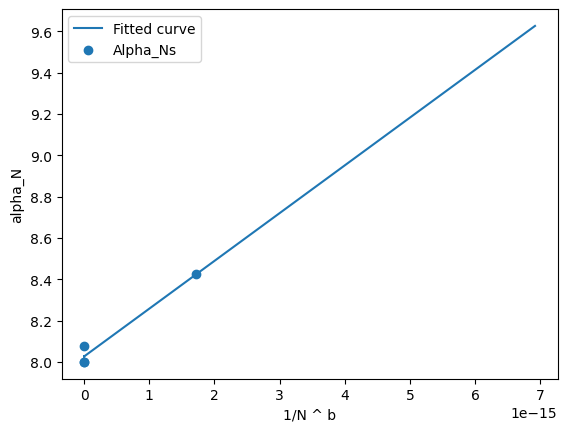

Extrapolated alpha at N ~ infinity: 8.026439751508628
Extrapolated alpha at N -> infinity: 8.026439751508628



In [11]:
grouped_df = df.groupby('N')

p_curves, alphas, Ns = [], [], []
for N, group in grouped_df:
    alphas, means, sems = [], [], []
    alpha_group = group.groupby('alpha')
    for a, g in alpha_group:
        p_mean, p_sem = g["Solved"].mean(), g["Solved"].std()/np.sqrt(g["Solved"].shape[0])
        alphas.append(a)
        means.append(p_mean)
        sems.append(p_sem)

    p_curves.append(means)
    Ns.append(N)

x = np.array(alphas)
y1, y2, y3, y4, y5 = p_curves[0], p_curves[1], p_curves[2], p_curves[3], p_curves[4]

popt1, _ = curve_fit(logistic_fit, x, y1, bounds=([0., -np.inf, 0., 8.], [np.inf, np.inf, np.inf, 10.]), maxfev=5000)
popt2, _ = curve_fit(logistic_fit, x, y2, bounds=([0., -np.inf, 0., 8.], [np.inf, np.inf, np.inf, 10.]), maxfev=5000)
popt3, _ = curve_fit(logistic_fit, x, y3, bounds=([0., -np.inf, 0., 8.], [np.inf, np.inf, np.inf, 10.]), maxfev=5000)
popt4, _ = curve_fit(logistic_fit, x, y4, bounds=([0., -np.inf, 0., 8.], [np.inf, np.inf, np.inf, 10.]), maxfev=5000)
popt5, _ = curve_fit(logistic_fit, x, y5, bounds=([0., -np.inf, 0., 8.], [np.inf, np.inf, np.inf, 10.]), maxfev=5000)
f1 = lambda x: logistic_fit(x, *popt1)
f2 = lambda x: logistic_fit(x, *popt2)
f3 = lambda x: logistic_fit(x, *popt3)
f4 = lambda x: logistic_fit(x, *popt4)
f5 = lambda x: logistic_fit(x, *popt5)

# Find the x where the curves intersect (or are closest to intersecting) via least squares optimization 
def intersection_objective_n1(x):
    return (f1(x) -f2(x))**2
result = minimize(intersection_objective_n1, x0=[8.6], bounds=[(8., 9.75)])
p1_x_intersection = result.x[0]
p1_y_intersection = f1(p1_x_intersection)

def intersection_objective_n2(x):
    return (f2(x)-f3(x))**2
result = minimize(intersection_objective_n2, x0=[8.6], bounds=[(8., 9.75)])
p2_x_intersection = result.x[0]
p2_y_intersection = f2(p2_x_intersection)

def intersection_objective_n3(x):
    return (f3(x)-f4(x))**2
result = minimize(intersection_objective_n3, x0=[8.6], bounds=[(8., 9.75)])
p3_x_intersection = result.x[0]
p3_y_intersection = f3(p3_x_intersection)

def intersection_objective_n4(x):
    return (f4(x)-f5(x))**2
result = minimize(intersection_objective_n4, x0=[8.6], bounds=[(8., 9.75)])
p4_x_intersection = result.x[0] 
p4_y_intersection = f4(p4_x_intersection)

alpha_N_values = [p1_x_intersection, p2_x_intersection, p3_x_intersection, p4_x_intersection]
intersection_y_values = [p1_y_intersection, p2_y_intersection, p3_y_intersection, p4_y_intersection]

f = [f1, f2, f3, f4, f5]
for i in range(len(p_curves)):
    plt.plot(x, f[i](x))
    if i < len(alpha_N_values):
        plt.scatter(alpha_N_values[i], intersection_y_values[i], marker='o')
plt.xlabel('alpha')
plt.ylabel('P(solved)')
plt.tight_layout()
plt.show()

inverse_N = 1 / np.array(Ns)
inverse_N = inverse_N[:-1]
popt, _ = curve_fit(power_fit, inverse_N, alpha_N_values, bounds=[[6., -np.inf, -np.inf], [10., np.inf,  np.inf]],  maxfev=5000)
(m, a, b) = popt
x_range = np.linspace(0, 0.07, 100)
new_x = x_range ** b
new_y = m + a * new_x

plt.plot(new_x, new_y, label='Fitted curve')
plt.scatter(inverse_N ** b, alpha_N_values, label='Alpha_Ns')
plt.xlabel('1/N ^ b')
plt.ylabel('alpha_N')
plt.legend()
plt.show()

print("Extrapolated alpha at N ~ infinity:", power_fit(1e-10, *popt))
print("Extrapolated alpha at N -> infinity:", popt[0])
print()


In [12]:
#  calculate percentange of solvable (as per their label) instances that were actually solved
labels = pd.read_csv(os.path.normpath('../../datasets/4SAT/sc/test_labels-final.csv'))
print(df.shape, labels.shape)
sat_idx = np.where(labels.sat == 1)[0]
pred, gt = df.Solved[sat_idx], labels.sat[sat_idx]
print(pred.shape, gt.shape)
print('Solving accuracy:', (pred == gt).sum() / len(gt))

(21000, 6) (21000, 3)
(18421,) (18421,)
Solving accuracy: 0.5107757450735574


In [13]:
df[df['E'] == 0].shape, df.shape

KeyError: 'E'